In [ ]:
# Import packages
import nhd_network
import xarray as xr
from functools import partial
import json
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple

In [ ]:
# Set path to state-specific RouteLink file
path = "al_routelink.nc"
ds = xr.open_dataset(path)

In [ ]:
# Subset dataset to useful information
subslice = [
    "link",
    "to",
    "gages",
]
df = ds[subslice].to_dataframe().astype({"link": int, "to": int,})
df = df.set_index("link")

In [ ]:
def replace_downstreams(data: pd.DataFrame, 
                        downstream_col: str, 
                        terminal_code: int) -> pd.DataFrame:
    '''
    Replace terminal basin (e.g. ocean, lake, reservoir) identifier with 
    (-1) * [identifier of basin directly upstream of terminal].

    Parameters
    ----------
    data : pd.DataFrame
        RouteLink file in DataFrame format. Each row represents properties of a 
        specific basin.
    downstream_col : str
        Name of column identifying what basin is directly downstream.
    terminal_code : int
        Code by which a terminal basin is identified.

    Returns
    -------
    pd.DataFrame
        Copy of data, but with original terminal code replaced by 
        (-1) * [identifier of basin directly upstream of terminal].
    '''
    ds0_mask = data[downstream_col] == terminal_code
    new_data = data.copy()
    new_data.loc[ds0_mask, downstream_col] = ds0_mask.index[ds0_mask]

    # Also set negative any nodes in downstream col not in data.index
    new_data.loc[~data[downstream_col].isin(data.index), downstream_col] *= -1
    return new_data


def organize_independent_networks(connections: dict) -> Tuple[dict, dict, dict]:
    ''' 
    Extract upstream/downstream connections from RouteLink file.

    Parameters
    ----------
    connections : dict
        Dictionary in the form 
        {segment id: [list of downstream adjacent segment ids]} 

    Returns
    -------
    dict 
        Dictionary in the form
        {segment id: [list of upstream adjacent segment ids]}
    '''
    rconn = nhd_network.reverse_network(connections)

    return rconn

In [ ]:
# Replace terminal identifiers
df = df.sort_index()
df = replace_downstreams(df, "to", 0)

# Get upstream/downstream connections
connections = nhd_network.extract_connections(df, "to")
rconn = organize_independent_networks(connections)

In [ ]:
def traverse(rconn: dict, root: int, num_upstreams: int) -> None:
    '''  
    Recursively traverse a network of connected basins to return the total 
    number of upstream basins connected to any given basin. These upstreams can 
    be directly or indirectly connected to the given basin. Note: this function
    only works for relatively small areas (e.g. a state) and fails when run over
    all of CONUS due to recursion depth limits.

    Parameters
    ----------
    rconn : dict
        Dictionary in the form
        {segment id: [list of upstream adjacent segment ids]}
    root : int
        ID of desired basin
    num_upstreams : dict
        Keys are basin IDs in the whole network. Values are the number of
        upstream basins counted for the corresponding basin ID. This dictionary
        is continually updated as this function recursively runs.
    '''
    num_upstreams[root] += len(rconn[root])
    for child in rconn[root]:
        traverse(rconn, child, num_upstreams)
        num_upstreams[root] += num_upstreams[child]

In [ ]:
# Count number of upstreams for every terminal basin
tailwaters = [x for x in list(rconn.keys()) if x < 0]
num_upstreams = {key: 0 for key in list(rconn.keys())}
for root in tailwaters:
    traverse(rconn, root, num_upstreams)

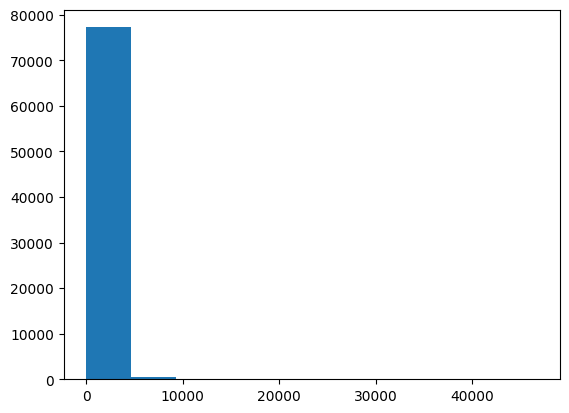

In [ ]:
# Plot distribution of number of upstreams per basin
vals = list(num_upstreams.values())
plt.hist(vals)
plt.show()

In [ ]:
# Select the basins with no upstreams (aka headwaters)
headwaters = [x for x in list(num_upstreams.keys()) 
              if num_upstreams[x] == 0]
# Select basin pairs from list of headwaters so that 1) upstream basins are all 
# headwaters and 2) downstream basins have one and only one upstream basin.
zero_one_pairs = {headwater: connections[headwater][0] 
                  for headwater in headwaters
                  if num_upstreams[connections[headwater][0]] == 1}

In [ ]:
# Save selected basin pairs to disk
with open('al_pairs.txt', 'w') as file:
    file.write(json.dumps(zero_one_pairs))